<a href="https://colab.research.google.com/github/nastenkass/homeworkMachineLearning/blob/main/Sem04_KNN_adv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# KNN

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/sem4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Общая схема решения задачи машинного обучения

__Вспомнить из лекции:__
* Что такое задача машинного обучения? Что дано и что необходимо найти?
* Какие бывают типы признаков в машинном обучении?
* Какие бывают виды задач в машинном обучении?
* Что такое функционал качества? Для чего он нужен?

Вспомним общую схему решения задачи машинного обучения:

<div style="text-align:center">
<img src="/content/drive/MyDrive/sem4/scheme.png" width="500"/>
</div>

Из исходной базы данных после предобработки мы получаем обучающую выборку $X, Y$. Матрица объекты-признаки $X$ имеет размер (число объектов) $\times$ (число признаков). Одна строка этой матрицы соответствует одному объекту обучающей выборки, заданному как вектор длины (число признаков). Признаки - числовые характеристики объекта. Вектор правильных ответов $Y$ имеет длину (число объектов).

На этапе обучения на основе обучающей выборки $X, Y$ строится (обучается) алгоритм $a(x)$. Это некая функция, которая берет на вход признаки объекта и возвращает предсказание для этого объекта: $y \approx a(x)$. Алгоритм $a$ может делать предсказания для любых допустимых объектов; его можно применять как к обучающим объектам, так и к тем, которых алгоритм никогда не видел. В этом и состоит цель машинного обучения: выявить такие закономерности в обучающей выборке, которые позволят делать качественные (довольно точные) предсказания на новых объектах $x$.

Тому, как обучать такие алгоритмы $a(x)$ по обучающей выборке, во многом и посвящен наш курс.

## Интерфейс Scikit-Learn

Scikit-Learn, или коротко Sklearn - библиотека, в которой реализованы практически все используемые сегодня алгоритмы машинного обучения. Нам необходимо познакомиться с интерфейсом библиотеки, чтобы понимать, как ее можно использовать на практике. Далее может понадобится не только использовать готовые реализации из sklearn, но иногда и самим реализовывать алгоритмы в том же духе, в котором это сделано в этой библиотеке (с тем же интерфейсом).

Для реализации алгоритмов машинного обучения в sklearn всегда используется один интерфейс - класс с функциями fit(X, Y) для обучения модели по обучающей выборке $X, Y$ и predict(X) для возвращения предсказаний на выборке $X$. При создании класса можно указывать дополнительные параметры, влияющие на работу алгоритма машинного обучения.

Например, такова будет логика работы класса линейной регрессии, которую мы подробно изучим на следующих семинарах:
* При создании класса нужно запомнить коэффициент регуляризации;
* Задача функции fit - по выборке X и Y найти веса w и сохранить их внутри класса в self.w;
* Задача функции predict - по весам self.w и X вернуть предсказания $Y$.

In [4]:
import numpy as np
import pandas as pd

In [7]:
# пример класса из sklearn
class LinearRegressor:
    def __init__(self, reg_coef: float = None) -> None:
        self.lambda_ = reg_coef

    def fit(self, X_train: np.array, y_train: np.array) -> None:
        from sklearn.linear_model import LinearRegression

        self.model = LinearRegression()

        self.model.fit(X_train, y_train)

    def predict(self, X_test: np.array) -> np.array:
        y_pred = self.model.predict(X_test)

        return y_pred

Если бы не использовали класс, нам пришлось бы передавать веса w в функцию predict каждый раз, когда мы захотели бы сделать предсказания, это неудобно (особенно если таких вспомогательных переменных много). А так веса хранятся внутри класса, и мы можем даже не догадываться об их существовании (если класс писали не мы).

Пример импорта классификатора из sklearn:

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

**Важный момент**: при использовании метрик из sklearn первым параметром указывается истинная переменная, а вторым - предсказание.

In [24]:
y_test = [5, 3, 6, 7, 123, 345, 10, 3452, 123, 687, 567, 129]
y_predicted = [10] * len(y_test)

accuracy_score(y_test, y_predicted)

0.08333333333333333

Помимо алгоритмов обучения и предсказания для разных методов, в sklearn реализовано много вспомогательного функционала для предобработки данных, визуализации данных, вычисления метрик качества и т. д. В ходе следующих семинаров мы постепенно познакомимся с этим функционалом библиотеки.

Сегодня мы познакомимся с методами предобработки данных и их реализацией в sklearn.

### Предобработка данных
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [13]:
X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"]
)
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


Разделим признаки и целевую переменную:

In [14]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

In [15]:
X_raw.isna().sum()

0      0
1     41
2      0
3      0
4      0
5      2
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     4
19     4
20     0
21     2
22     2
23     0
24     0
dtype: int64

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс `impute.SimpleImputer`.

In [16]:
from sklearn.impute import SimpleImputer

In [17]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
# категориальные признаки имеют тип "object"
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)

# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Всегда нужно анализировать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам.

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию `pd.get_dummies`.

In [18]:
print(f"Shape before encoding: {X_no_mis.shape}")
X_dum = pd.get_dummies(X_no_mis, drop_first=True, dtype=int)
X_dum

Shape before encoding: (205, 25)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1.0,95.0,109.1,188.8,68.9,55.5,2952.0,141.0,3.78,3.15,...,0,0,0,0,0,0,0,1,0,0
201,-1.0,95.0,109.1,188.8,68.8,55.5,3049.0,141.0,3.78,3.15,...,0,0,0,0,0,0,0,1,0,0
202,-1.0,95.0,109.1,188.8,68.9,55.5,3012.0,173.0,3.58,2.87,...,0,0,0,0,0,0,0,1,0,0
203,-1.0,95.0,109.1,188.8,68.9,55.5,3217.0,145.0,3.01,3.40,...,0,0,0,0,0,1,0,0,0,0


Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу. Это важно для численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел). Кроме того, у каждого метода машинного обучения есть свои особенности, требующие масштабирования признаков. Например, для линейных моделей - это ускорение обучения и повышение интерпретируемости модели.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (`StandardScaler` в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (`MinMaxScaler` в sklearn).

In [25]:
from sklearn import preprocessing

X_dum.columns = X_dum.columns.astype(str)

normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Пример реализации

Реализуем класс для нормализации данных по аналогии с интерфейсом sklearn для нормализации.

Предобработка данных в sklearn реализована по похожему шаблону, что и обучение моделей: функция `.fit(X)` запоминает внутренние переменные, а функция `.transform(X)` выполняет преобразование выборки. `y` здесь не нужен, потому что в нормализации целевые переменные не участвуют (как и почти во всей предобработке данных).

Параметров у класса нет, так что функцию `__init__` мы пропускаем. Функция `.fit()` считает статистики - среднееи стандартное отклонение каждого признака (по обучающей выборке), а функция `.tranform()` вычитает среднее и делит на стандартное отклонение. Для вычисления статистик используем numpy.

In [26]:
class Normalizer:
    def fit(self, X: np.array) -> None:
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0)

    def transform(self, X: np.array) -> np.array:
        return (X - self.mu[np.newaxis, :]) / self.sigma[np.newaxis, :]

Создаем случайные данные X и y для тестирования нашего класса:

In [27]:
num_obj_train = 20
num_obj_te = 10
num_feat = 4
X_train = np.random.randint(-5, 5, size=(num_obj_train, num_feat))
X_train.shape

(20, 4)

In [28]:
X_test = np.random.randint(-5, 5, size=(num_obj_te, num_feat))
X_test.shape

(10, 4)

In [29]:
X_train

array([[ 3,  2, -5,  2],
       [ 4, -5,  4, -2],
       [ 4, -2, -1,  3],
       [-5,  2,  0, -5],
       [ 0,  2,  1,  2],
       [-1,  0,  3, -1],
       [-4, -3,  2,  3],
       [-4, -3, -4, -2],
       [ 4,  4,  0,  0],
       [ 4,  3, -2, -3],
       [-3, -1, -5,  4],
       [ 2, -5, -5,  3],
       [ 0, -3,  4,  1],
       [ 4, -1,  4,  4],
       [-5,  2,  1,  3],
       [-5,  3,  3,  1],
       [-3, -2, -1,  4],
       [-2, -5,  1,  2],
       [ 3, -1, -2, -1],
       [-2, -1,  0, -5]])

Создаем объект класса и трансформируем выборку:

In [30]:
normalizer = Normalizer()
normalizer.fit(X_train)
X_train_transformed = normalizer.transform(X_train)
X_test_transformed = normalizer.transform(X_test)

Fit нужно вызывать именно на обучающих данных, чтобы ничего не подсмотреть в контрольной выборке. А transform можно вызывать много раз для любых выборок (с уже посчитанным статистиками, которые хранятся внутри класса).

In [31]:
X_train_transformed

array([[ 0.96435179,  0.97238125, -1.66221115,  0.47947464],
       [ 1.25657961, -1.54860717,  1.39082974, -0.94119096],
       [ 1.25657961, -0.46818356, -0.30530409,  0.83464104],
       [-1.37347074,  0.97238125,  0.03392268, -2.00669017],
       [ 0.08766834,  0.97238125,  0.37314944,  0.47947464],
       [-0.20455947,  0.25209884,  1.05160297, -0.58602456],
       [-1.08124292, -0.82832477,  0.71237621,  0.83464104],
       [-1.08124292, -0.82832477, -1.32298439, -0.94119096],
       [ 1.25657961,  1.69266365,  0.03392268, -0.23085816],
       [ 1.25657961,  1.33252245, -0.64453085, -1.29635736],
       [-0.7890151 , -0.10804236, -1.66221115,  1.18980744],
       [ 0.67212398, -1.54860717, -1.66221115,  0.83464104],
       [ 0.08766834, -0.82832477,  1.39082974,  0.12430824],
       [ 1.25657961, -0.10804236,  1.39082974,  1.18980744],
       [-1.37347074,  0.97238125,  0.37314944,  0.83464104],
       [-1.37347074,  1.33252245,  1.05160297,  0.12430824],
       [-0.7890151 , -0.

## Метрические методы. k Nearest Neighbours

### Теоретическая часть


__Вспомнить из лекции:__
* Как в методе k ближайших соседей выполняются предсказания в задаче классификаци и регрессии?
* Что такое гипотеза компактности?
* Какие функции расстояния можно использовать для вещественных признаков, категориальных признаков, строковых признаков, множественнозначных признаков?

#### Задача 1.
Предположим, мы решаем задачу классификации на три класса по двум признакам и используем метод k ближайших соседей с k=3 и манхэттанской метрикой. Мы имеем следующую обучающую выборку:

| Признак 1 | Признак 2 | Класс |
|-----------|-----------|-------|
| 1         | -1        | 1     |
| 2         | 2         | 1     |
| 3         | 2         | 2     |
| 1         | 0         | 3     |
| 2         | -2        | 3     |

Каковы будут предсказания для объекта $x=(S, -P)$? Где $S$ - номер по списку `% 4`, $P$ - номер по списку `% 3 + 1`.

Формула манхэттанской метрики:
$$\rho(x,z)=\sum_{j=1}^d|x_i-z_i|$$

__Решение.__

*your answer*

In [46]:
from sklearn.neighbors import KNeighborsClassifier

X_train = [[1, -1], [2, 2], [3, 2], [1, 0], [2, -2]]
y_train = [1, 1, 2, 3, 3]

S = 5 % 4
P = 5 % 3 + 1

knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

knn.fit(X_train, y_train)

x = [[S, -P]]
predicted_value = knn.predict(x)

print("Предсказание для объекта x =", x[0], ":", predicted_value[0])

Предсказание для объекта x = [1, -3] : 3


#### Задача 2.
Визуализируйте разделяющую поверхность между классами для следующей выборки:

| Признак 1 | Признак 2 | Класс |
|-----------|-----------|-------|
| 2         | 2        | 1     |
| 3         | 2         | 1     |
| 2         | 0         | 2     |
| 1         | -1         | 3     |
| 1        | 1        | 3     |
| $S$        | $-P$        | класс     |

Используйте k=1 и евклидово расстояние.

__Решение.__

*your answer*

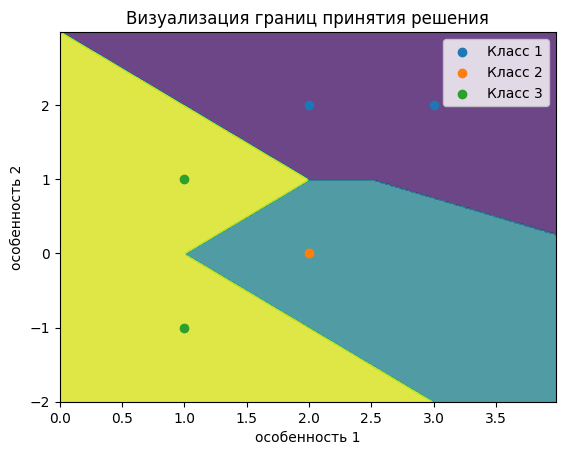

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

X_train = np.array([[2, 2], [3, 2], [2, 0], [1, -1], [1, 1]])
y_train = np.array([1, 1, 2, 3, 3])

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')


knn.fit(X_train, y_train) # обучаем

h = .02  # шаг сетки
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)

# разделяющая поверхность
plt.contourf(xx, yy, Z, alpha=0.8)

# точки обучающей выборки
for i, class_label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == class_label][:, 0],
                X_train[y_train == class_label][:, 1],
                label=f'Класс {class_label}')

plt.xlabel('особенность 1')
plt.ylabel('особенность 2')
plt.title('Визуализация границ принятия решения')
plt.legend()
plt.show()

#### Задача 3.
Предположим, мы решаем задачу регрессии по двум признакам и используем метод k ближайших соседей с k=3 и манхэттанской метрикой. Мы имеем следующую обучающую выборку:

| Признак 1 | Признак 2 | Ответ |
|-----------|-----------|-------|
| 1         | -1        | 3.5     |
| 2         | 2         | 2.3     |
| 3         | 2         | 1.7     |
| 1         | 0         | -0.4     |
| 2         | -2        | 0.1     |

Каковы будут предсказания для объекта $x=(S, -P)$?

__Решение.__

*your answer*

In [44]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

X_train = np.array([[1, -1], [2, 2], [3, 2], [1, 0], [2, -2]])
y_train = np.array([3.5, 2.3, 1.7, -0.4, 0.1])

knn_regressor = KNeighborsRegressor(n_neighbors=3, metric='manhattan')

S = 5 % 4
P = 5 % 3 + 1

x = np.array([[S, -P]])

knn_regressor.fit(X_train, y_train)

predicted_value2 = knn_regressor.predict(x)

print("Предсказание для объекта x =", x[0], ":", predicted_value2[0])

Предсказание для объекта x = [ 1 -3] : 1.0666666666666667


#### Вопрос: каковы параметры и гиперпараметры метода kNN?
__Ответ:__

Параметры - это величины, которые мы настраиваем в процессе обучения по обучающей выборке. В методе kNN нет как такового обучения - это очень простой эвристический алгоритм. Под параметрами в kNN можно понимать обучающую выборку. В другой трактовке у метода нет параметров.

Гиперпараметры - это величины, которые мы должны установить до начала обучения модели. Гиперпараметры не настраиваются по обучающей выборке в процессе обучения модели. Два самых важных гиперпараметры метода kNN - это число соседей k и метрика. Используя разные комбинации этих гиперпараметров, можно получать совершенно разное качество работы алгоритма. Гиперпараметры обычно настраивают по валидационной выборке или используя кросс-валидацию.

#### Какова динамика качества работы kNN при увеличении k?

__Ответ:__

При $k=1$ вокруг каждого объекта обучающей выборки создается область его класса. Если, к примеру, в "большую" область одного класса случайно попал один шумовой объект другого класса, вокруг этого шумового объекта будет "остров" предсказания другого класса. Это нелогично и говорит о переобучении.

При $k$, равном числу объектов в выборке, для всех объектов будет предсказываться одно и то же, что вновь говорит о низком качестве работы классификатора. Получается, что качество kNN при увеличении $k$ должно сначала расти, а потом падать, и оптимум будем где-то посередине.

Рассмотрим синтетический пример: на рисунке визуализирована обучающая выборка ("настоящая" разделяющая поверхность - прямая) и разделяющая поверхность kNN по аналогии с задачей 2, и на разных графиках используется разное число соседей $k$:

<div>
<img src="img/k_grid.png" width="550"/>
</div>

При использовании малых $k$ разделяющая поверхность слишком сложная, на нее оказывают сильное воздействие шумовые объекты. Далее поверхность становится все ровнее и ровнее и при $k=50$ выглядит наиболее разумно. При большем k разделяющая поверхность уходит от линейной, и оранжевый класс "захватывает" синий.

#### Почему при использовании kNN важно нормировать данные?

__Ответ:__

Рассмотрим для примера манхэттэнскую метрику. Если один признак будет иметь масштаб около 1000, а другой - около 1, то когда мы будем складывать модули разностей для этих двух признаков, второй признак практически не будет иметь влияния на ответ. Если же признаки отнормировать, но они все будут в одной шкале.

### Практическая часть

In [47]:
import numpy as np
import pandas as pd
import sklearn

# изображения цифр
from sklearn.datasets import load_digits
# классификатор
from sklearn.neighbors import KNeighborsClassifier
# шаффлер данных
from sklearn.utils import shuffle

In [48]:
clf = KNeighborsClassifier(n_neighbors=3)

data = load_digits()
X = data.images
y = data.target

X.shape

(1797, 8, 8)

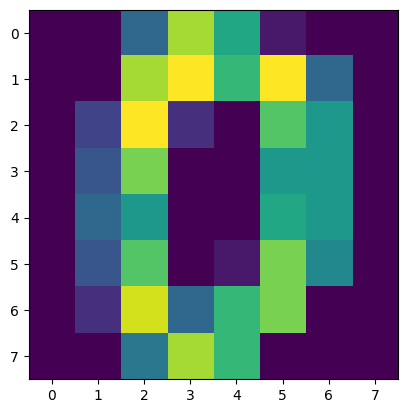

In [49]:
import matplotlib.pyplot as plt
plt.imshow(X[0])
plt.show()

In [50]:
X[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [51]:
# вытягиваем квадратное изображение в вектор, чтобы получить матрицу объекты-признаки
X = X.reshape(X.shape[0], -1)

# перемешиваем данные
X, y = shuffle(X, y)
print(f"Features shape: {X.shape},\nTarget shape: {y.shape}")
print(f"Target samples: {y[:10]}")

Features shape: (1797, 64),
Target shape: (1797,)
Target samples: [1 9 5 0 7 7 5 5 3 5]


In [52]:
X_train, y_train = X[:700, :], y[:700]
X_val, y_val = X[700:1300, :], y[700:1300]
X_test, y_test = X[1300:, :], y[1300:]

In [53]:
# Обучаем классификатор и делаем предсказания
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)

In [54]:
# Вычисляем простейшую метрику качества алгоритма - долю правильных ответов
print("Accuracy is: ", np.mean(y_test==y_predicted))

Accuracy is:  0.9818913480885312


In [55]:
from sklearn.manifold import TSNE
tsne = TSNE()
res = tsne.fit_transform(X)

In [56]:
res

array([[ 10.182447 ,  -8.943774 ],
       [-21.555882 ,  26.95329  ],
       [  5.9341073,  16.865923 ],
       ...,
       [-34.872387 , -22.259935 ],
       [-23.848043 ,  15.805495 ],
       [ 16.127245 ,  -8.13677  ]], dtype=float32)

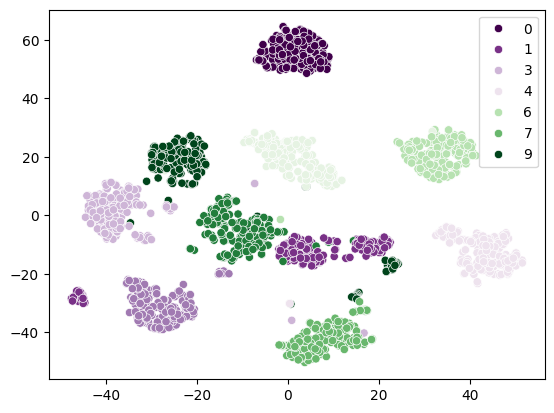

In [57]:
import seaborn as sns
sns.scatterplot(x=res[:, 0], y=res[:, 1], hue=y, palette='PRGn')
plt.show()

Учитывая, что у нас 10 классов, и вероятность случайно вытащить два одинаковых маленькая, точность 0.969 - очень хороший результат!

Попробуем использовать разные значения гиперпараметра k. Сравнивать разные значения k по обучающей выборке бесполезно: каждый объект является ближайшим сам к себе и оптимальное k будет равно 1. Будем сравнивать разные k по качеству на валидационной выборке:

In [58]:
# Подбор k на валидационной выборке:
for k in range(1, 21):
    y_predicted = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).predict(X_val)
    print(f"k = {k}; accuracy = {np.mean(y_predicted==y_val):.3f}")

k = 1; accuracy = 0.973
k = 2; accuracy = 0.960
k = 3; accuracy = 0.972
k = 4; accuracy = 0.970
k = 5; accuracy = 0.973
k = 6; accuracy = 0.968
k = 7; accuracy = 0.972
k = 8; accuracy = 0.972
k = 9; accuracy = 0.970
k = 10; accuracy = 0.970
k = 11; accuracy = 0.968
k = 12; accuracy = 0.962
k = 13; accuracy = 0.960
k = 14; accuracy = 0.955
k = 15; accuracy = 0.948
k = 16; accuracy = 0.952
k = 17; accuracy = 0.948
k = 18; accuracy = 0.947
k = 19; accuracy = 0.945
k = 20; accuracy = 0.945


Наилучший результат при k=5.

Сравним точность (accuracy) на обучении, валидации и тесте:

In [59]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

for X_data, y_data in zip([X_train, X_val, X_test], [y_train, y_val, y_test]):
    y_predicted = clf.predict(X_data)
    print(f"Accuracy: {np.mean(y_predicted==y_data):.3f}")

Accuracy: 0.987
Accuracy: 0.973
Accuracy: 0.978


Качество на обучающей выборке самое лучшее, но оно обманчиво, ведь алгоритм уже знает эти объекты (переобучение).
На валидационной выборке мы тоже использовали ответы - уже для подбора гиперпараметра k, так что этот показатель тоже не совсем честный.
И действительно, качество на тестовой выборке (ответы для которой мы нигде не подсматривали) оказалось хуже, чем на валидационной выборке.

_Вывод_: оценивать качество алгоритма нужно на отложенной выборке, которая не используется нигде в обучении и не используется в подборе гиперпараметров.